# Семинар 2 - Цветовые пространства, гистограммы изображений, интегральные изображения

***

**Данный семинар содержит оцениваемые упражнения и вопросы.**

Система оценивания: доля правильно решенных упражений. Максимальный балл, соответственно, 1.

В упражнениях оценивается два аспекта:
1. Код проходит assert'ы (если они есть)
2. Код корректен с точки зрения логики

Вопросы также оцениваются. Ответ на них нужно записывать в соответствующие markdown-ячейки.

Источник используемого аэрофотоснимка: https://sovzond.ru/upload/medialibrary/267/%D0%98%D1%81%D1%85%D0%BE%D0%B4%D0%BD%D1%8B%D0%B9-%D0%B0%D1%8D%D1%80%D0%BE%D1%84%D0%BE%D1%82%D0%BE%D1%81%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA.jpg

In [2]:
from pathlib import Path

import cv2
import numpy as np

import matplotlib.pyplot as plt

In [3]:
AERIAL_IMG_PATH = "data/aerial_image.jpg"
SUNFLOWER_IMG_PATH = "data/sunflower.jpg"

if not Path(AERIAL_IMG_PATH).exists() or not Path(SUNFLOWER_IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2024.git
    !mv cv_course_2024/seminars/seminar_02/data .

Cloning into 'cv_course_2024'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 44 (delta 5), reused 5 (delta 5), pack-reused 36
Receiving objects: 100% (44/44), 10.73 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (8/8), done.


## 1. Цветовые пространства

Наиболее распространенным представлением цвета пикселя является пространство RGB. В таком представлении цвет представлен тремя числами: интенсивностями красного, зеленого и синего базисных цветов.

In [4]:
img = cv2.imread(SUNFLOWER_IMG_PATH)

In [5]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

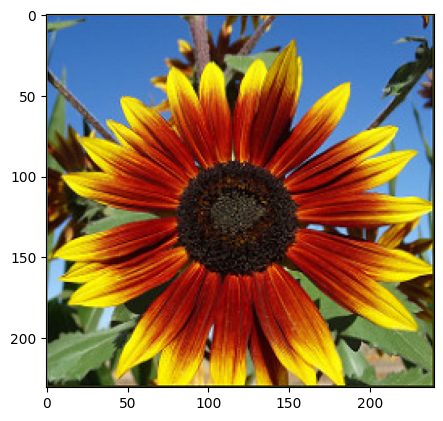

In [6]:
plt.figure(figsize=[5, 5])
plt.imshow(img_rgb)

cvtColor поддерживает конвертацию между множеством других цветовых схем. К примеру, чтобы получить серое изобаржение из цветного достаточно:

In [7]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

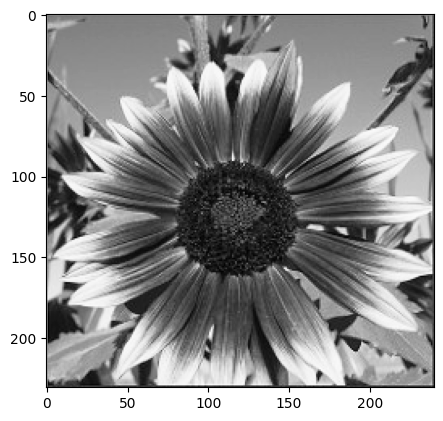

In [8]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

Если не предполагается использовать информацию о цвете пикселей, то можно сразу загрузить изображение в оттенках серого:

In [9]:
img_gray = cv2.imread(SUNFLOWER_IMG_PATH, cv2.IMREAD_GRAYSCALE)

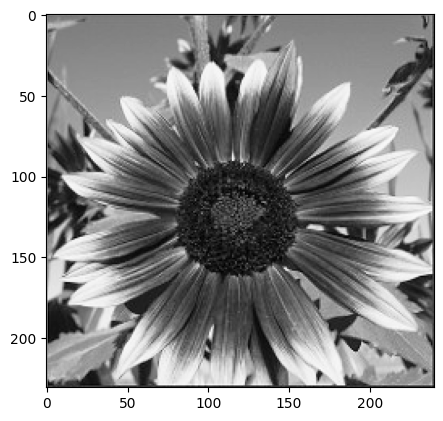

In [10]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

серое изображение - двумерный массив:

In [11]:
print('type(img_gray) = ', type(img_gray))
print('img_gray.shape = ', img_gray.shape)
print('img_gray.dtype = ', img_gray.dtype)

type(img_gray) =  <class 'numpy.ndarray'>
img_gray.shape =  (231, 240)
img_gray.dtype =  uint8


## Упражнение 1: RGB $\to$ gray

**Это и все последующие упражения - оцениваемые, для самостоятельной работы.**

Реализуйте функцию преобразования цветного изображения в формате RGB в серое

In [17]:
def convert_rgb_to_grayscale(img_rgb):
    img_gray = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype = 'uint8')
    img_gray = np.round(0.29901*img_rgb[:, :, 0] + 0.58701*img_rgb[:, :, 1] + 0.1140*img_rgb[:, :, 2])
    return img_gray

In [18]:
assert((cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) == convert_rgb_to_grayscale(img_rgb)).all())

## Вопрос 1

**Этот и все последующие вопросы - оцениваемые, для самостоятельной работы.**

Почему бы не использовать при преобразовании в серое просто среднее арифметическое?

**Ответ:** восприятие цвета человеческим глазом максимально чувствительно к свету в зелёном диапазоне спектра

Кроме RGB/BGR и grayscale существуют и другие цветовые представления. Преобразования между ними можно осуществлять с помощью библиотеки OpenCV следующим способом:

## RGB $\to$ HSV

In [19]:
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

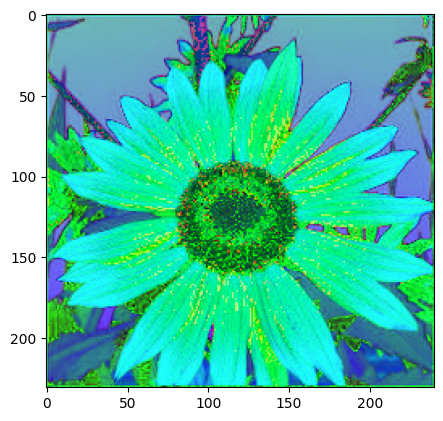

In [20]:
plt.figure(figsize=[5, 5])
plt.imshow(img_hsv)

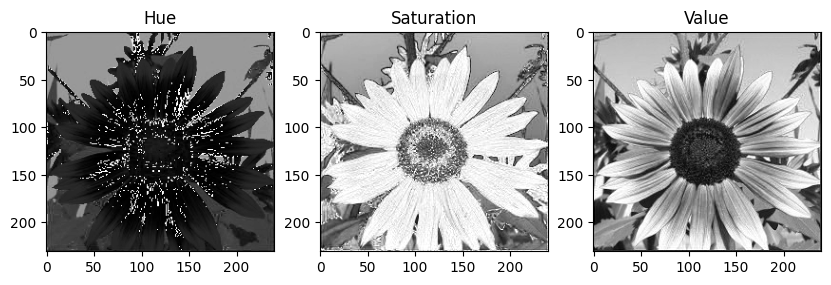

In [21]:
# Split the image into color channels
h, s, v = cv2.split(img_hsv)

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(h, cmap="gray")
plt.title('Hue')

plt.subplot(132)
plt.imshow(s, cmap="gray")
plt.title('Saturation')

plt.subplot(133)
plt.imshow(v, cmap="gray")
plt.title('Value')

# Display the plot
plt.show()


## Упражнение 2

Попробуйте другие цветовые пространства, конвертация в которые реализована в OpenCV.

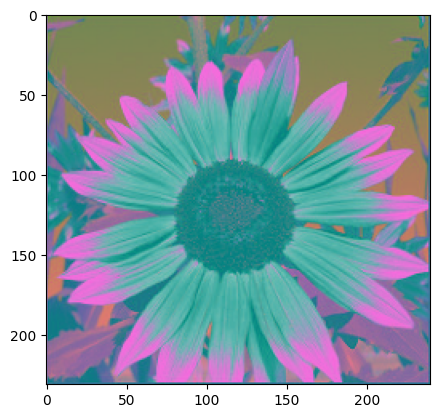

In [24]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
plt.imshow(img)

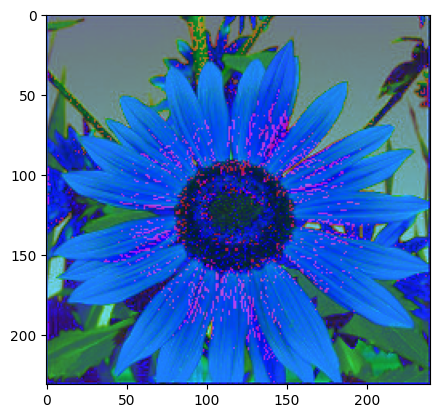

In [25]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
plt.imshow(img)

## Вопрос 2

В каких задачах переход из RGB в другое цветовое пространство может быть полезным?

**Ответ:** переход для выделения оттенков или в градации серого для уменьшения сложности, облегчение отслеживания объектов по цвету, выявления контуров и текстур

## Гистограмма изображения

Напомним, что гистограммой изображения называется функция, показыващая количество пикселей изображения с заданным в качестве аргумента значением интенсивности:

$$
    h(v) = \sum_{x = 0}^{W - 1} \sum_{y = 0}^{H - 1} [f(x, y) = v]
$$

Если дополнительно потребовать, чтобы $\sum_{v = 0}^{255} h(v) = 1$, то $h$ будет представлять функцию плотности распределения интенсивности на изображении.

Определим вспомогательную функцию, позволяющую визализировать гистограмму:

In [26]:
def visualize_hist(hist):
    plt.figure(figsize=[20, 5])
    plt.bar(np.arange(len(hist)), hist / hist.sum())

Рассчитать гистограмму можно с помощью встроенной функции OpenCV:

In [27]:
hist_cv = cv2.calcHist([img_gray],      # список изображений
                       [0],             # список каналов
                       None,            # маска (без маски)
                       [256],           # размер гистограммы
                       [0, 256])[:, 0]  # диапазон значений

Результат представляет собой обычный массив длины 256:

In [28]:
print('hist_cv.shape = ', hist_cv.shape)

hist_cv.shape =  (256,)


и выглядит следующим образом:

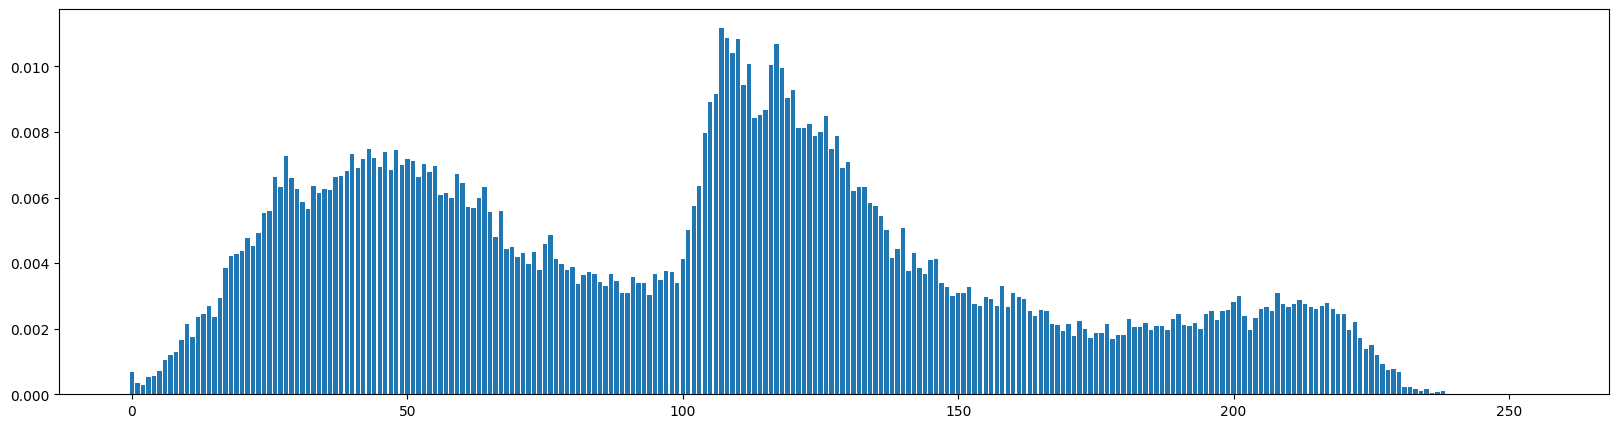

In [29]:
visualize_hist(hist_cv)

## Упражнение 3: Построение гистограммы

Реализуйте функцию для расчета гистограммы изображения. Используйте ее для визуализации трех каналов RGB изображения.

In [36]:
def compute_hist(img):
    return np.bincount(img.ravel(), minlength=256)

In [37]:
hist_gray = compute_hist(img_gray)

hist_r = compute_hist(img_rgb[:, :, 0])
hist_g = compute_hist(img_rgb[:, :, 1])
hist_b = compute_hist(img_rgb[:, :, 2])

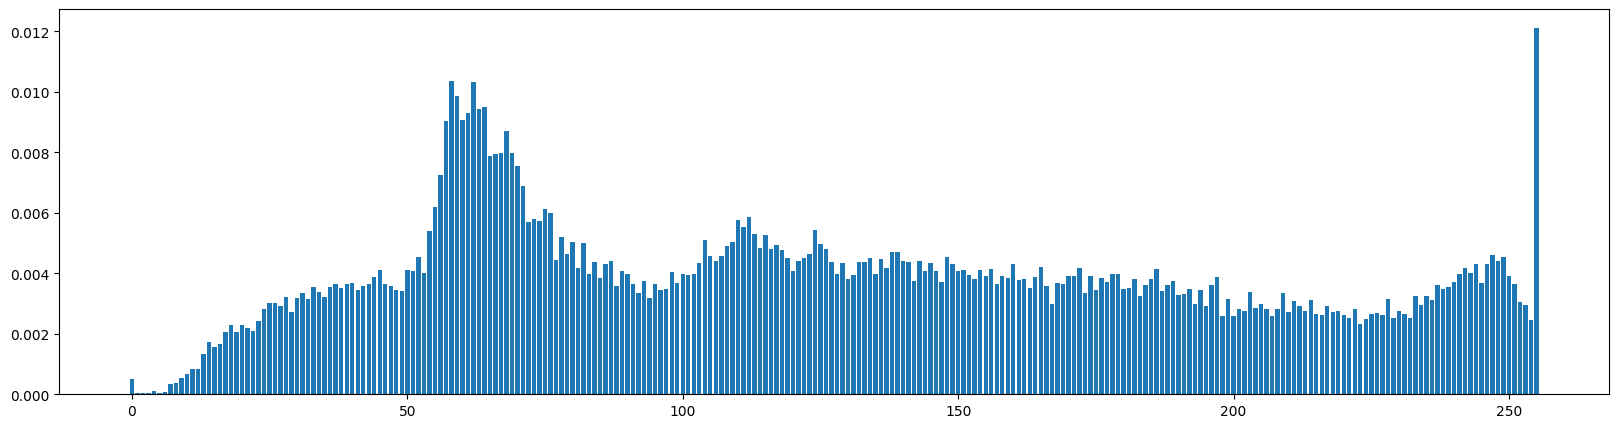

In [38]:
visualize_hist(hist_r)

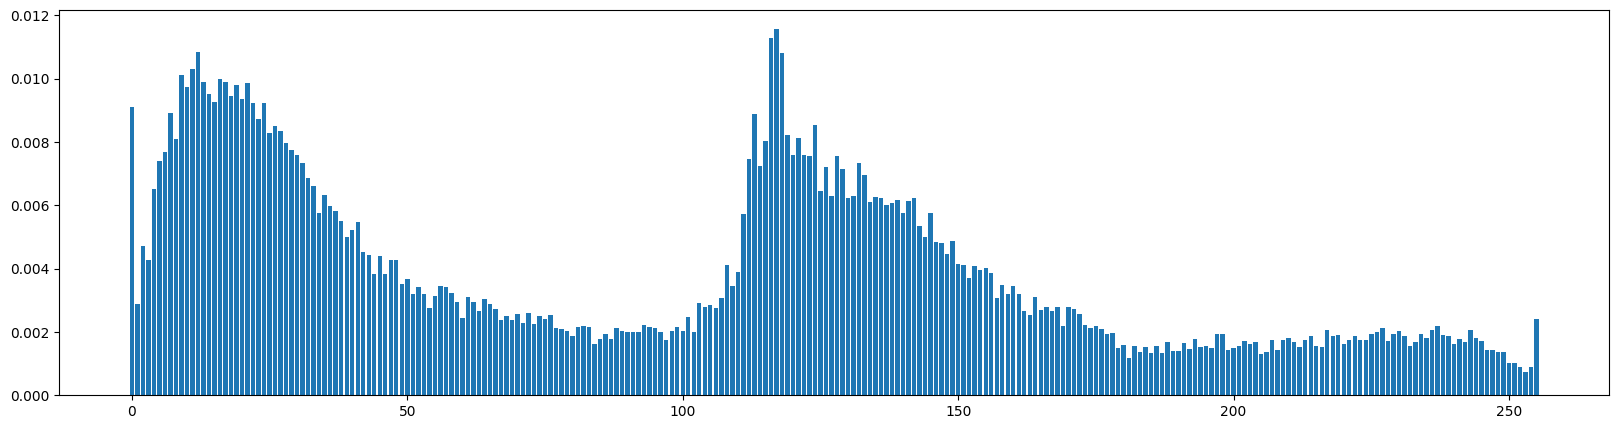

In [39]:
visualize_hist(hist_g)

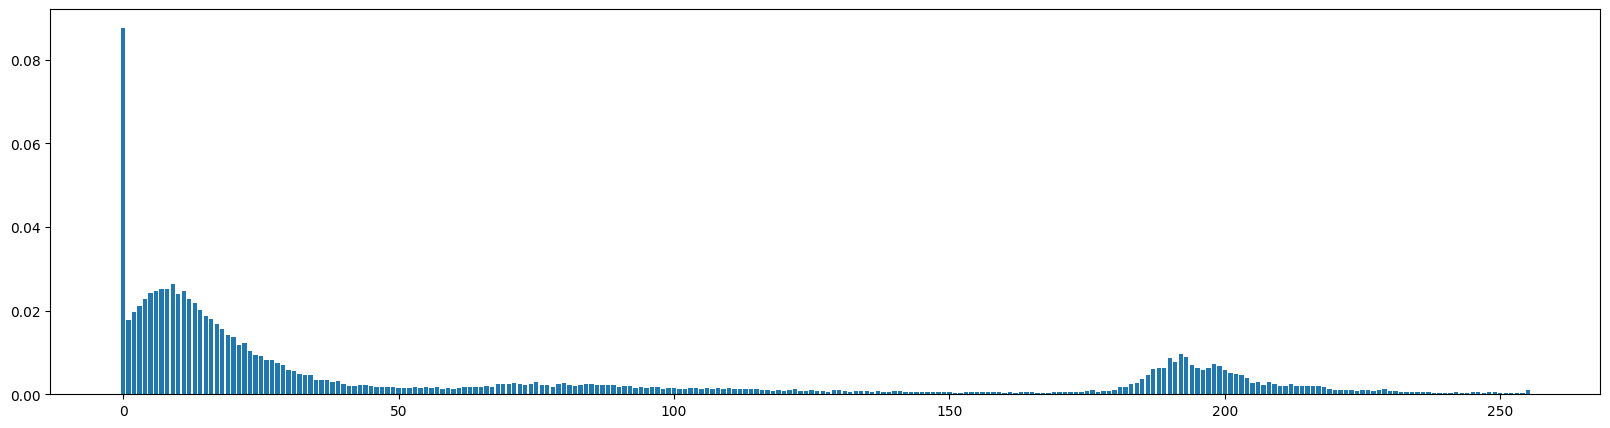

In [40]:
visualize_hist(hist_b)

In [41]:
assert((hist_gray == hist_cv).all())

## Вопрос 3

 Что можно сказать об изображении по его гистограмме?

**Ответ:** оценить разнообразие оттенков и распределение яркости

## Вопрос 4

Допустим, вы смотрите некоторый фильм и для текущего кадра выводите его гистограмму. Как будет меняться эта гистограмма с течением времени?

**Ответ:** слабо, кроме случаев, когда произошла резкая смена кадра

## Упражнение 4: JPEG и гистограмма

Исследуйте, как влияет степень сжатия алгоритма JPEG на вид гистограммы изображения.

Используйте черно-белое изображение `img_gray`. Визуализируйте степени сжатия 90, 60, 30, 5.

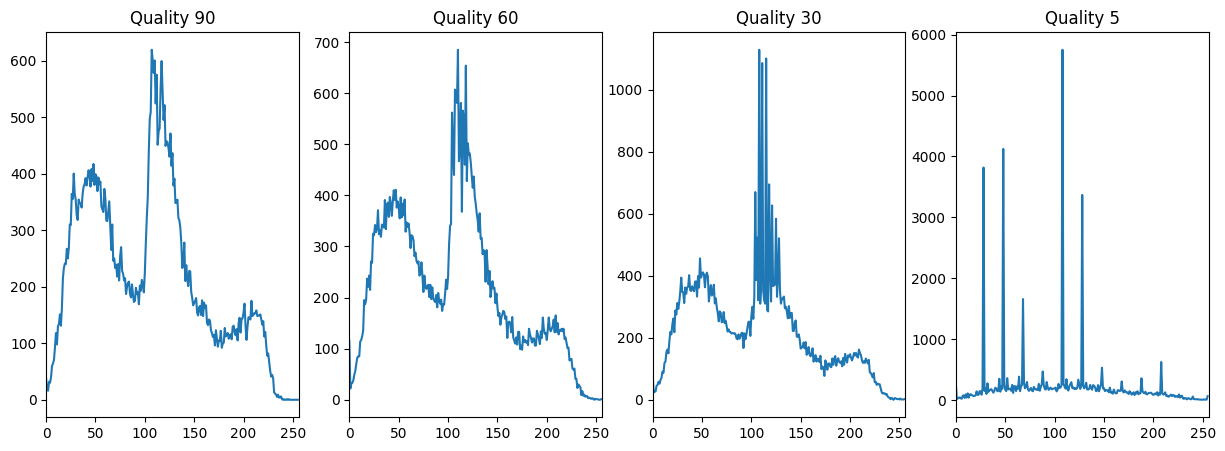

In [46]:
def compress_and_histogram(img, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, img_encoded = cv2.imencode('.jpg', img, encode_param)
    img_compressed = cv2.imdecode(img_encoded, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img_compressed], [0], None, [256], [0, 256])
    return hist

img_gray = cv2.imread('/content/data/sunflower.jpg', cv2.IMREAD_GRAYSCALE)
qualities = [90, 60, 30, 5]

plt.figure(figsize=(15, 5))
for i, quality in enumerate(qualities, 1):
    hist = compress_and_histogram(img_gray, quality)
    plt.subplot(1, len(qualities), i)
    plt.plot(hist)
    plt.title(f'Quality {quality}')
    plt.xlim([0, 256])

plt.show()

## Упражнение 5: Сегментация

На загруженном аэроортофотоплане выделите зеленые насаждения. Для этого постройте бинарную маску, где 1 будет отвечать наличию насаждений в данном пикселе, 0 - их отсутствию, и визуализируйте её. А также рассчитайте, какую долю изображения занимают зеленые насаждения. С какой ошибкой (погрешностью) получена эта величина?

Подсказка: вам должно помочь HSV пространство и гистограмма. Погрешность может быть оценена на глаз, по вашей неуверенности в определении порога отделения классов 'зеленые насаждения'/'прочее'.

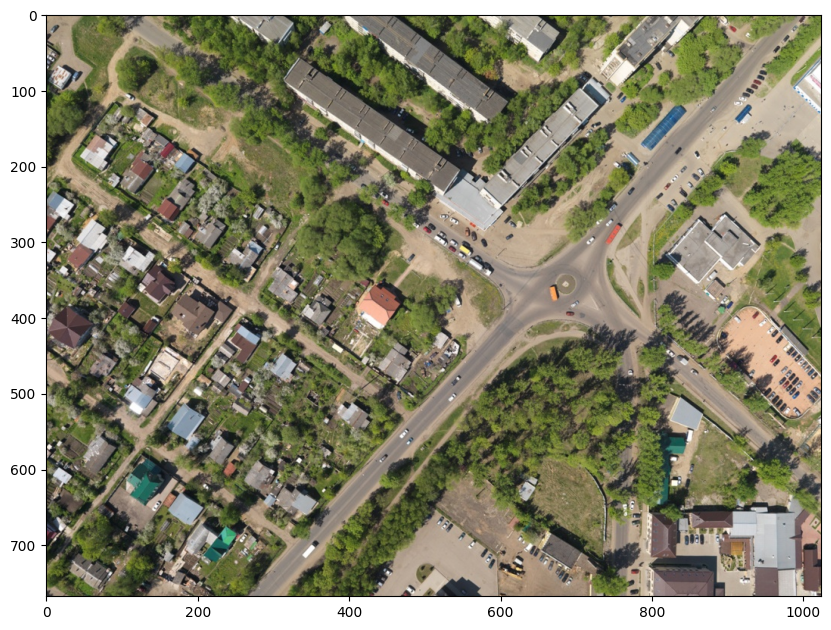

In [47]:
aerial_image = cv2.cvtColor(cv2.imread(AERIAL_IMG_PATH), cv2.COLOR_BGR2RGB)

plt.figure(figsize=[10, 10])
plt.imshow(aerial_image)

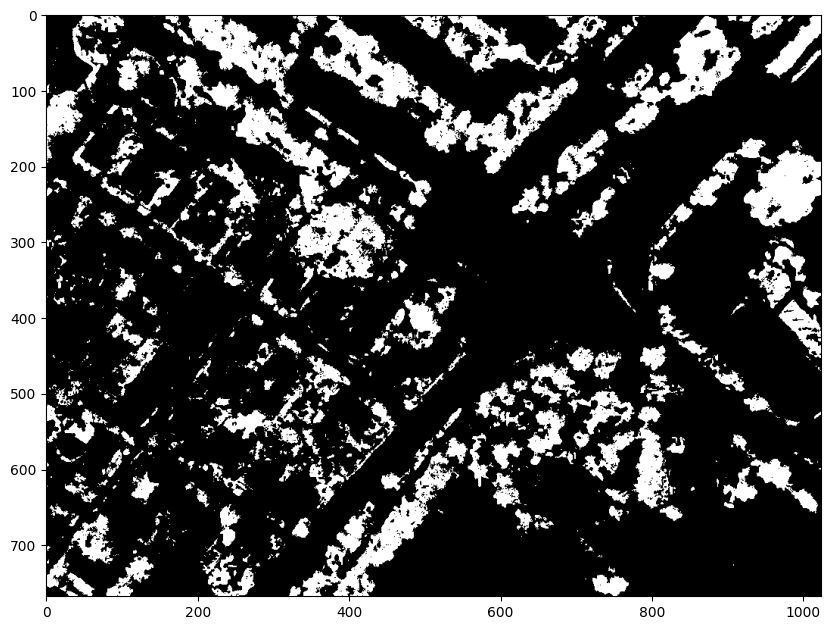

prc: 19.8%


In [51]:
hsv_image = cv2.cvtColor(aerial_image, cv2.COLOR_RGB2HSV)

green_l = np.array([35, 100, 50])
green_u = np.array([85, 255, 255])

mask = cv2.inRange(hsv_image, green_l, green_u)
plt.figure(figsize=[10, 10])
plt.imshow(mask, cmap='gray')
plt.show()
green_area = np.sum(mask == 255) / mask.size
print(f"prc: {green_area:.1%}")

# Упражнение 6: Интегральное изображение
Напомним, что интегральным изображением называется следующая функция:
$$
    I(x, y) = \sum_{i = 0}^{x} \sum_{j = 0}^{y} f(i, j)
$$
С помощью интегрального изображения можно за $O(1)$ вычислять сумму интенсивностей в произвольной прямоугольной области. Требуется реализовать расчет интегрального изображения, а также быстрый расчет сумм интенсивностей в прямоугольнике заданном верхним левым углом, шириной и высотой $x, y, w, h$.

In [52]:
class IntegralImage:

    def __init__(self, img):
        assert(len(img.shape) == 2)  # только для серых изображений

        self.img = img
        self.integral_img = self.calculate_integral(img)

    def calculate_integral(self, img):
        integral_img = np.zeros(img.shape, dtype=np.int32)
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                integral_img[y, x] = img[y, x]
                if y > 0:
                    integral_img[y, x] += integral_img[y - 1, x]
                if x > 0:
                    integral_img[y, x] += integral_img[y, x - 1]
                if x > 0 and y > 0:
                    integral_img[y, x] -= integral_img[y - 1, x - 1]

        return integral_img

    def sum(self, x, y, w, h):
        x_e = x + w - 1
        y_e = y + h - 1

        area_sum = self.integral_img[y_e, x_e]
        if y > 0:
            area_sum -= self.integral_img[y - 1, x_e]
        if x > 0:
            area_sum -= self.integral_img[y_e, x - 1]
        if x > 0 and y > 0:
            area_sum += self.integral_img[y - 1, x - 1]

        return area_sum


In [53]:
I = IntegralImage(img_gray)

In [54]:
x, y, w, h = 0, 0, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

x, y, w, h = 100, 100, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

## Вопрос 5

В каких задачах может потребоваться использовать интегральное изображение?

**Ответ:** вычисление яркости каких-то участков изображения

## Вопрос 6

Какому методу решения задачи в программировании следует метод расчета интегрального изображения?

**Ответ:** линейного программирования